### Agent training
In this notebook, a DQN agent is traing to solve the Navigation environment

In [1]:
# installing requirements
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.18 which is incompatible.


### 1. Introducing Hyperparameters

In [2]:
INPUT_SIZE = 37         # state size
NUM_ACTIONS = 4         # the number of possible actions

AVG_SOL_REWARD = 13.0   # over the window of 100 episode, the min average reward to stop
FC1_UNITS = 128
# I would like to urge the agent not to take too much actions without a reward 
# e.g. moving left and right to avoid a blue banana will call it (idle_reward)
# for that, I penalize actions with 0 rewards
# However, that penalty shall decreas as we advance further in the episode
# Because, most likely it needs to travel further to find more yellow bananas
idle_reward_start = -0.5
idle_reward_decay = 0.8

### 2. Setting up the environment

In [3]:
from unityagents import UnityEnvironment
env = UnityEnvironment(file_name="/data/Banana_Linux_NoVis/Banana.x86_64")
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]


INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


### 3. Instantiating the Agent

In [4]:
from dqn_agent import Agent
from model import QNetwork
import torch

SEED = 13
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#create the agent
agent = Agent(action_size=NUM_ACTIONS,
              seed=SEED,
              qnetwork_local = QNetwork(INPUT_SIZE, NUM_ACTIONS, SEED, FC1_UNITS).to(device),
              qnetwork_target = QNetwork(INPUT_SIZE, NUM_ACTIONS, SEED, FC1_UNITS).to(device))

### 3. The training loop

In [6]:
import numpy as np
from collections import deque
import torch.optim as optim
from replay_buffer import ReplayBuffer

def dqn(n_episodes=10000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    
    for i_episode in range(1, n_episodes+1):        
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations[0]
        score = 0
        idle_reward = idle_reward_start
        while True:
            #print(f'\ridle_reward: {idle_reward}', end="")
            #print(f'idle_reward: {idle_reward}')
            action = agent.act(state, eps)
            env_info = env.step(action)[brain_name]        # send the action to the environment
            next_state = env_info.vector_observations[0]   # get the next state
            reward = idle_reward if env_info.rewards[0] == 0 else env_info.rewards[0] # get the reward
            done = env_info.local_done[0]                  # see if episode has finished
            
            agent.step(state, action, reward, next_state, done)
            
            state = next_state
            score += reward
            idle_reward *= idle_reward_decay
            if done:
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=AVG_SOL_REWARD:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'model.pt')
            break
    return scores

scores = dqn()



Episode 100	Average Score: -2.13
Episode 200	Average Score: 0.044
Episode 300	Average Score: 2.05
Episode 400	Average Score: 3.91
Episode 500	Average Score: 5.63
Episode 600	Average Score: 6.06
Episode 700	Average Score: 7.52
Episode 800	Average Score: 9.38
Episode 900	Average Score: 10.29
Episode 1000	Average Score: 12.26
Episode 1100	Average Score: 12.18
Episode 1200	Average Score: 12.90
Episode 1201	Average Score: 13.01
Environment solved in 1101 episodes!	Average Score: 13.01


### 4. Plot the scores

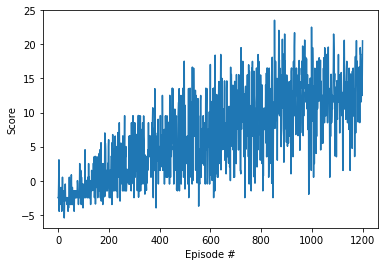

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [8]:
env.close()